# The interplay between resampling and PVEc 

Attempting to re-create the same results presented in the PhD thesis on a larger dataset. 
These results are drawn from the pCASL reproducibility dataset (8 subjects, 3 sessions, repeats at session, week and month), 3.5 x 3.5 x 4.95mm multi-PLD data. 

Setup: 
CBF estimation with oxford_asl, PVEc with spatial VB, PVs estimated using FAST and Toblerone. 

PVEc using four strategies (in each case using spatial VB): 
- native space 
- common space, naive PV estimates (a direct downsampling from structural)
- common space, double resampled (estimate in native space first then transform back to common)
- common space, post transform (do native space PVEc and then transform the results onto common)

In [2]:
import pandas as pd 
import numpy as np 
import nibabel as nib
import os.path as op 
import itertools 
from scipy import stats 

import matplotlib.pyplot as plt 
import seaborn as sns 

import pipeline 

In [3]:
index_tups = [] 
data = [] 

def load_cbf(oxdir, pvec=False): 
    if not pvec: 
        gm_path = op.join(oxdir, 'output', 'native', 'perfusion_calib.nii.gz')
        paths = [gm_path, gm_path]
    else: 
        gm_path = op.join(oxdir, 'output_pvcorr', 'native', 'perfusion_calib.nii.gz')
        wm_path = op.join(oxdir, 'output_pvcorr', 'native', 'perfusion_wm_calib.nii.gz')
        paths = [gm_path, wm_path]
    return [ nib.load(p).get_fdata().astype(np.float32) for p in paths ]

def load_pvs(oxdir):
    gm_path = op.join(oxdir, 'input', 'pvgm.nii.gz')
    wm_path = op.join(oxdir, 'input', 'pvwm.nii.gz')
    return [ nib.load(p).get_fdata().astype(np.float32) for p in [gm_path, wm_path] ]

def load_mask(oxdir): 
    m = op.join(oxdir, 'input', 'mask.nii.gz')
    return nib.load(m).get_fdata().astype(bool)

for sub in pipeline.SUBJECTS: 
    for (sess,run),meth,pvcorr in itertools.product(
            pipeline.SESS_RUNS[sub], ['tob','fast'], [True,False]): 
        # print('Loading', sub, sess, run, meth, pvcorr)
        to_load = [] 

        # Native
        index_tups.append(( sub, sess, run, 'native', meth, pvcorr ))
        oxdir = pipeline.oxasl_path(sub=sub, sess=sess, 
                run=run, space='native', pvec=meth)
        to_load.append(oxdir)

        # Common naive 
        index_tups.append(( sub, sess, run, 'common_naive', meth, pvcorr ))
        oxdir = pipeline.oxasl_path(sub=sub, sess=sess, 
                run=run, space='common', pvec=meth, suffix='naive')
        to_load.append(oxdir)
        
        # Common double
        index_tups.append(( sub, sess, run, 'common_double', meth, pvcorr ))
        oxdir = pipeline.oxasl_path(sub=sub, sess=sess, 
                run=run, space='common', pvec=meth, suffix='double')
        to_load.append(oxdir)

        # Common post 
        index_tups.append(( sub, sess, run, 'common_post', meth, pvcorr ))
        oxdir = pipeline.oxasl_path(sub=sub, sess=sess, 
                run=run, space='common', pvec=meth, suffix='post')
        to_load.append(oxdir)

        for oxdir in to_load: 
            gcbf = wcbf = gpv = wpv = m = None 
            try: 
                gcbf,wcbf = load_cbf(oxdir, pvcorr)
                if oxdir.count('post'): 
                    oxdir = pipeline.oxasl_path(sub=sub, sess=sess, 
                        run=run, space='common', pvec=meth, suffix='naive')
                gpv,wpv = load_pvs(oxdir)
                m = load_mask(oxdir)

            except FileNotFoundError as e: 
                print('Could not load', oxdir)

            finally:         
                d = { 'gm_cbf': gcbf, 'wm_cbf': wcbf, 'pvgm': gpv, 'pvwm': wpv, 'mask': m }
                data.append(d)
      
assert len(index_tups) == len(data)
index = pd.MultiIndex.from_tuples(index_tups, 
        names=['sub', 'sess', 'run', 'strategy', 'method', 'pvcorr'])
df = pd.DataFrame(data, index=index, dtype=object)

NameError: name 'new' is not defined

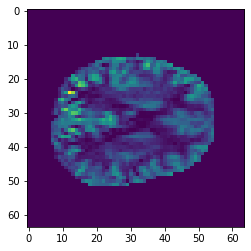

In [ ]:
x = df.loc[2,'A',1,'native','tob',False]['gm_cbf']
plt.imshow(x[...,12])

## Does resampling introduce extra PVE?

We assess this by looking at distributions of uncorrected CBF - more PVE should lead to a more 'normal' distribution. For each subject, plot the distribution for native space and common space (resampled) data. 

Text(0.5, 0.98, 'CBF distributions before/after resampling')

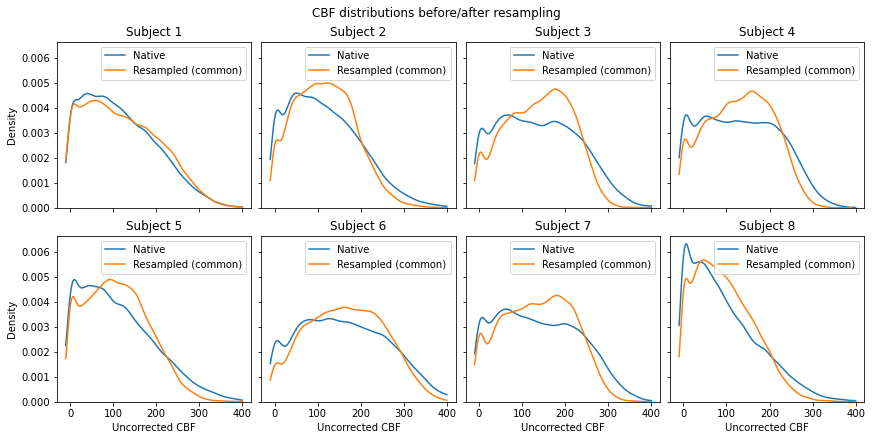

In [ ]:
df.index[0]
fig, axes = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(12,6), constrained_layout=True)
for idx,sub in enumerate(pipeline.SUBJECTS): 

    ax = axes[idx//4, idx%4]
    cbf_nat, nat_mask = df.loc[sub,'A',1,'native','tob',False][['gm_cbf','mask']]
    sns.kdeplot(cbf_nat[nat_mask], ax=ax, label='Native', clip=[-10,400])
    cbf_cmn, cmn_mask = df.loc[sub,'A',1,'common_naive','tob',False][['gm_cbf','mask']]
    sns.kdeplot(cbf_cmn[cmn_mask], ax=ax, label='Resampled (common)', clip=[-10,400])
    ax.legend()
    ax.set_title(f'Subject {sub}')
    ax.set_xlabel('Uncorrected CBF')
    
fig.suptitle('CBF distributions before/after resampling')

For some subjects, the change in distribution is clearly larger - this is perhaps related to the magnitude of the registration transform that was required to bring the data into common space? Ie, if the registration is small, then little change in distribution. 

## Analysis of GM PV vs CBF linear regression

We expect an approximately linear relationship between GM PV and uncorrected CBF. We use the regression coefficient $R$ to assess how well GM PV explains the observed CBF. This is calculated per subject, per acquisition, for the native, common-naive and common-double strategies. We expect that the native and double strategies will have higher $R$ values than common-naive because the PVs used in those strategies better reflect the PVE embedded in the actual ASL data. If this is true, then it follows that PVEc with those two strategies will be "better", because the PV estimates themselves are "better". 

In [ ]:
def do_regression(row): 
    try: 
        mask = row['mask'] & (row['pvgm'] > 0.1)
        reg = stats.linregress(row['pvgm'][mask], row['gm_cbf'][mask])
        return reg.rvalue 
    except: 
        return None 

regs = df.loc[:,:,:,['native','common_naive','common_double'],:,False].apply(do_regression, axis=1).reset_index()
regs.head()

,sub,sess,run,strategy,method,pvcorr,0
0,1,A,1,native,tob,False,0.119725
1,1,A,1,native,fast,False,0.141412
2,1,B,1,native,tob,False,0.223754
3,1,B,1,native,fast,False,0.224815
4,1,C,1,native,tob,False,0.237474


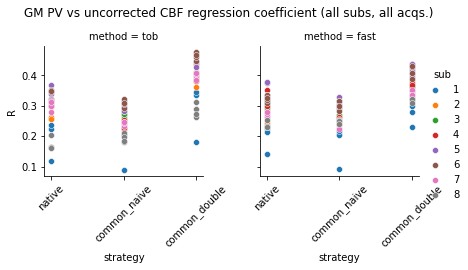

In [ ]:
regs.rename(columns={0: 'R'}, inplace=True)
grid = sns.FacetGrid(regs, col='method', hue="sub")
grid.map(sns.scatterplot, "strategy", "R")
grid.set_xticklabels(rotation=45)
grid.add_legend()
grid.fig.suptitle('GM PV vs uncorrected CBF regression coefficient (all subs, all acqs.)')
grid.fig.subplots_adjust(top=0.8)

1. common-double returns higher R values than common-naive for both Tob and FAST. This is as expected. 
2. common-double also returns higher R values than native for both PV estimation methods. This is a bit surprising: we would expect native space to give the highest results because the data has not be corrupted in any way. The likely explanation is that the resampling of ASL data entailed by the common-double strat has the side-effect of reducing noise via smoothing and this flatters the result. 

## CoV with GM PV bins between repeats 

Similar to the analysis presented in the original paper for which this data was acquired, we measure CoV within voxels binned according to their GM PV. CoV is measured for the session repeat, week repeat and month repeat. The reference metric here is no PVEc because one mooted justification for performing PVEc is that it can improve repeatability of CBF measurement. 

We expect no PVEc and common-naive to perform badly. Common-double and common-post (transform after PVEc) should perform better. 

In [ ]:
strat_mapper = {
    'no PVEc' : ('common_naive', False), 
    'naive PVEc' : ('common_naive', True), 
    'double PVEc' : ('common_double', True), 
    'post PVEc' : ('common_post', True), 
}

bins = np.arange(0.2, 1.2, 0.2)

def calc_cov_in_bins(ref, other, pvgm, bins): 
    if ref.isna().values.any() or other.isna().values.any(): 
        return [ (b, np.nan) for b in bins ]

    pvgm_bins = np.digitize(pvgm, bins)
    mask = ref['mask']
    cbf_a = ref['gm_cbf']
    cbf_b = other['gm_cbf']
    result = []
    cov = np.abs(cbf_a - cbf_b) / (0.5 * (cbf_a + cbf_b))
    cov[np.isnan(cov)] = 0 
    result = [ (b, cov[(pvgm_bins == idx) & mask].mean()) for idx,b in enumerate(bins) ] 

    return result

tups = [] 
for sub,meth in itertools.product(pipeline.SUBJECTS, ['tob','fast']): 

    pvgm = df.loc[sub,'B',1,'common_naive',meth,False]['pvgm']

    for out,(strat,pvec) in strat_mapper.items():

        # establish the session in which the sess-repeat took place
        # (it is the only session that contains repeat 2)
        ref_sess = df.loc[sub,:,2,strat,'fast',pvec].index[0]
        other_sess = df.loc[sub,ref_sess,2,strat,'fast',pvec]
        ref_sess = df.loc[sub,ref_sess,1,strat,'fast',pvec]
        bin_cov = calc_cov_in_bins(ref_sess, other_sess, pvgm, bins)
        tups += [ (sub, 'sess', meth, out, *bc) for bc in bin_cov ]

        # week repeat is between A and B 
        ref_sess = df.loc[sub,'A',1,strat,'fast',pvec]
        other_sess = df.loc[sub,'B',1,strat,'fast',pvec]
        bin_cov = calc_cov_in_bins(ref_sess, other_sess, pvgm, bins)
        tups += [ (sub, 'week', meth, out, *bc) for bc in bin_cov ]

        # month repeat is between A and C
        ref_sess = df.loc[sub,'A',1,strat,'fast',pvec]
        other_sess = df.loc[sub,'C',1,strat,'fast',pvec]
        bin_cov = calc_cov_in_bins(ref_sess, other_sess, pvgm, bins)
        tups += [ (sub, 'month', meth, out, *bc) for bc in bin_cov ]

covs = pd.DataFrame.from_records(tups, columns=['sub', 'repeat', 'method', 'strategy', 'gm_pv', 'cov'])
covs['gm_pv'] -= (bins[1] - bins[0]) / 2
covs = covs[covs['gm_pv'] > 0.2]
idx = pd.MultiIndex.from_frame(covs.iloc[:,:-1])
covs = covs.groupby(['repeat','method','strategy','gm_pv']).mean('sub').reset_index().drop(['sub'], axis=1)
covs.head(5)

/var/folders/lv/mwp4mfb163n5t2wqyhm281vm0000gn/T/ipykernel_69106/1979646399.py:19: RuntimeWarning: invalid value encountered in true_divide
  cov = np.abs(cbf_a - cbf_b) / (0.5 * (cbf_a + cbf_b))


,repeat,method,strategy,gm_pv,cov
0,month,fast,double PVEc,0.3,0.315512
1,month,fast,double PVEc,0.5,0.315935
2,month,fast,double PVEc,0.7,0.308282
3,month,fast,double PVEc,0.9,0.361182
4,month,fast,naive PVEc,0.3,0.323981


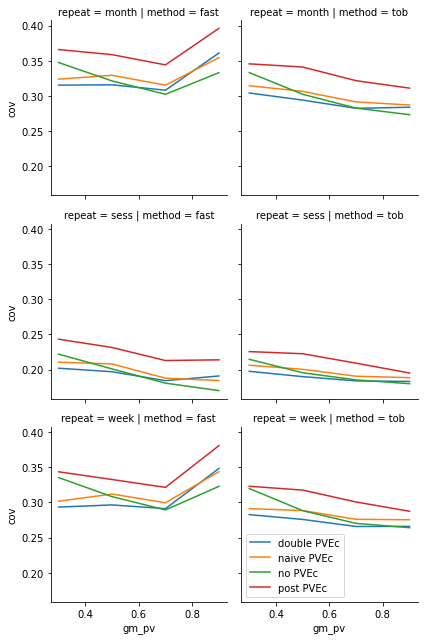

In [ ]:
grid = sns.FacetGrid(covs, row='repeat', col='method', sharey=True)
grid.map_dataframe(sns.lineplot, x="gm_pv", y="cov", hue='strategy')
plt.legend()

1. No PVEc performs comparably to all the PVEc strategies. This is a surprise and demonstrates the methodological challenege of PVEc: if you don't do it well, you will not gain improved repeatability. 
2. Post PVEc performs relatively badly. This could be because it contains more contrast in the native space CBF corrected maps (ie, bright spots and dark spots that reflect genuine physiological variation) that are well-preserved by the post-PVEc transformation. By contrast, the naive and double strategies resample the data before doing PVEc and hence the input data will be fundamentally smoother, so it is less likely these features would be preserved by such a strategy. Hence, by smoothing the data more, these two strategies will inherently produce lower CoV. 
3. It's worth pointing out that we don't know what ground truth CoV should be in this analysis - it will definitely not be zero, and hence it is difficult to rank strategies based solely on this metric. 
4. Toblerone's CoV seems to be lower than FAST's for the week and month repeat. For the session repeat there's not much in it. Are we seeing the impact of a larger misalignment for the week/month repeats (ie, more registration required), and perhaps Toblerone is better able to cope with it?

## Comparison of GM PV vs uncorrected CBF linear regression coefficient for Tob & FAST

Same analysis as presented earlier, but does one PV estimation method produce consistently different regression coefficients? Analysis treats each acquisition from each subject as independent (no grouping within subjects)

In [ ]:
def do_regression(row): 
    try: 
        mask = row['mask'] & (row['pvgm'] > 0.1)
        reg = stats.linregress(row['pvgm'][mask], row['gm_cbf'][mask])
        return reg.rvalue 
    except: 
        return None 

regs = df.loc[:,:,:,'native',:,False].apply(do_regression, axis=1)
regs = regs.unstack('method').reset_index()
regs.head(5)

method,sub,sess,run,fast,tob
0,1,A,1,0.141412,0.119725
1,1,A,2,0.235894,0.257429
2,1,B,1,0.224815,0.223754
3,1,C,1,0.212424,0.237474
4,2,A,1,0.297669,0.297670


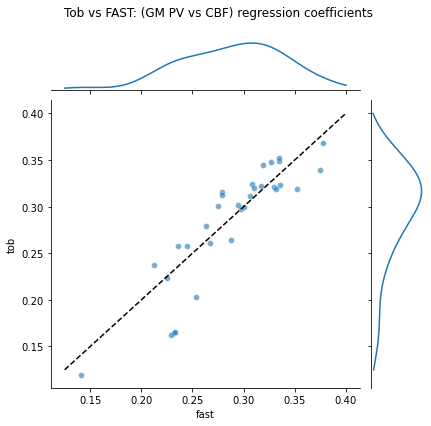

In [ ]:
grid = sns.JointGrid(data=regs, x='fast', y='tob')
grid.plot_joint(sns.scatterplot, alpha=.6, legend=False)
grid.plot_marginals(sns.kdeplot, clip=[0.125,0.4])
grid.ax_joint.plot([0.125,0.4], [0.125,0.4], 'k--')
grid.fig.suptitle("Tob vs FAST: (GM PV vs CBF) regression coefficients")
grid.fig.subplots_adjust(top=0.9)
plt.show()

No significant difference between the two. 